## Clustering overview

So far, we've looked at regression and classification. These are both types of **supervised machine learning**. In supervised learning, you train an algorithm to predict an unknown variable from known variables.

Another major type of machine learning is called **unsupervised learning**. In unsupervised learning, we aren't trying to predict anything. Instead, we're finding patterns in data.

One of the main unsupervised learning techniques is called clustering. We use clustering when we're trying to explore a dataset, and understand the connections between the various rows and columns. For example, we can cluster NBA players based on their statistics. Here's how such a clustering might look:

![Jupyter](./nba-clustering.png)

The clusters made it possible to discover player roles that might not have been noticed otherwise. Here's an article that describes how the clusters were created.

Clustering algorithms group similar rows together. There can be one or more groups in the data, and these groups form the clusters. As we look at the clusters, we can start to better understand the structure of the data.

Clustering is a key way to explore unknown data, and it's a very commonly used machine learning technique. In this mission, we'll work on clustering US Senators based on how they voted.

## The dataset

`114_congress.csv` contains all of the results of roll call votes from the 114th Senate. Each row represents a single Senator, and each column represents a vote. A `0` in a cell means the Senator voted `No` on the bill, `1` means the Senator voted `Yes`, and `0.5` means the Senator abstained.

Here are the relevant columns:

* `name` -- The last name of the Senator.
* `party` -- the party of the Senator. The valid values are `D` for Democrat, `R` for Republican, and `I` for Independent.
* Several columns numbered like `00001`, `00004`, etc. Each of these columns represents the results of a single roll call vote.

Clustering voting data of Senators is particularly interesting because it can expose patterns that go deeper than party affiliation. For example, some Republicans are more liberal than the rest of their party. Looking at voting data can help us discover the Senators who are more or less in the mainstream of their party.

In [32]:
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
votes = pd.read_csv('114_congress.csv')

In [3]:
votes.head()

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
0,Alexander,R,TN,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Ayotte,R,NH,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,Baldwin,D,WI,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
3,Barrasso,R,WY,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,Bennet,D,CO,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [4]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    100 non-null    object 
 1   party   100 non-null    object 
 2   state   100 non-null    object 
 3   00001   100 non-null    float64
 4   00004   100 non-null    float64
 5   00005   100 non-null    float64
 6   00006   100 non-null    float64
 7   00007   100 non-null    float64
 8   00008   100 non-null    float64
 9   00009   100 non-null    float64
 10  00010   100 non-null    float64
 11  00020   100 non-null    float64
 12  00026   100 non-null    float64
 13  00032   100 non-null    float64
 14  00038   100 non-null    float64
 15  00039   100 non-null    float64
 16  00044   100 non-null    float64
 17  00047   100 non-null    float64
dtypes: float64(15), object(3)
memory usage: 14.2+ KB


## Exploring the data

In [5]:
votes['party'].value_counts()

R    54
D    44
I     2
Name: party, dtype: int64

In [6]:
votes.mean()

00001    0.325
00004    0.575
00005    0.535
00006    0.945
00007    0.545
00008    0.415
00009    0.545
00010    0.985
00020    0.525
00026    0.545
00032    0.410
00038    0.480
00039    0.510
00044    0.460
00047    0.370
dtype: float64

## Distance between Senators

To find the distance between two rows, we can use Euclidean distance. The formula is:

$d = \sqrt{(q_1-p_1)^2 + (q_2-p_2)^2 + \cdots + (q_n-p_n)^2}$

To compute Euclidean distance in Python, we can use the euclidean_distances() method in the scikit-learn library. 

In [20]:
distance = euclidean_distances(votes.iloc[0,3:].values.reshape(1,-1), votes.iloc[2,3:].values.reshape(1,-1))

In [17]:
votes.iloc[0,3:].values.reshape(1,-1)

array([[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0,
        0.0, 0.0]], dtype=object)

## Initial clustering

We'll use an algorithm called k-means clustering to split our data into clusters. k-means clustering uses Euclidean distance to form clusters of similar Senators. We'll dive more into the theory of k-means clustering and build the algorithm from the ground up in a later mission. For now, it's important to understand clustering at a high level, so we'll leverage the scikit-learn library to train a k-means model.

The k-means algorithm will group Senators who vote similarly on bills together, in clusters. Each cluster is assigned a center, and the Euclidean distance from each Senator to the center is computed. Senators are assigned to clusters based on which one they are closest to. From our background knowledge, we think that Senators will cluster along party lines.

The k-means algorithm requires us to specify the number of clusters upfront. Because we suspect that clusters will occur along party lines, and the vast majority of Senators are either Republicans or Democrats, we'll pick `2` for our number of clusters.

We'll use the KMeans class from scikit-learn to perform the clustering. Because we aren't predicting anything, there's no risk of overfitting, so we'll train our model on the whole dataset. After training, we'll be able to extract cluster labels that indicate what cluster each Senator belongs to.

We can initialize the model like this:

**kmeans_model = KMeans(n_clusters=2, random_state=1)**

The above code will initialize the k-means model with 2 clusters, and a random state of 1 to allow for the same results to be reproduced whenever the algorithm is run.

We'll then be able to use the [fit_transform()](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_transform) method to fit the model to votes and get the distance of each Senator to each cluster. 

In [24]:
kmeans_model = KMeans(n_clusters=2, random_state=1)

senator_distances = kmeans_model.fit_transform(votes.iloc[:,3:])
senator_distances

array([[1.3134775 , 3.12141628],
       [2.05339992, 2.6146248 ],
       [3.41651746, 0.33960656],
       [0.24198446, 3.42004795],
       [2.96866004, 1.43833966],
       [3.41651746, 0.33960656],
       [0.24198446, 3.42004795],
       [3.41651746, 0.33960656],
       [0.24198446, 3.42004795],
       [3.30758755, 0.31287498],
       [3.41651746, 0.33960656],
       [0.96734144, 3.27058526],
       [3.41651746, 0.33960656],
       [0.53945585, 3.34875646],
       [3.41651746, 0.33960656],
       [3.12695614, 1.18084816],
       [3.13536063, 1.23852221],
       [0.24198446, 3.42004795],
       [0.24198446, 3.42004795],
       [0.24198446, 3.42004795],
       [2.05339992, 2.6146248 ],
       [3.31421108, 0.58487332],
       [0.24198446, 3.42004795],
       [0.24198446, 3.42004795],
       [0.24198446, 3.42004795],
       [0.24198446, 3.42004795],
       [0.93036231, 3.56324683],
       [0.24198446, 3.42004795],
       [2.82326711, 1.73847904],
       [3.41651746, 0.33960656],
       [0.

## Exploring the clusters

In [27]:
labels = kmeans_model.labels_

In [28]:
pd.crosstab(labels, votes['party'])

party,D,I,R
row_0,,,
0,3,0,54
1,41,2,0


## Exploring Senators in the wrong cluster

In [31]:
votes['labels'] = labels
democratic_outliers = votes[(votes['party'] == 'D')&(votes['labels'] == 0)]
democratic_outliers

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047,labels
42,Heitkamp,D,ND,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
56,Manchin,D,WV,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0
74,Reid,D,NV,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0


## Plotting out the clusters

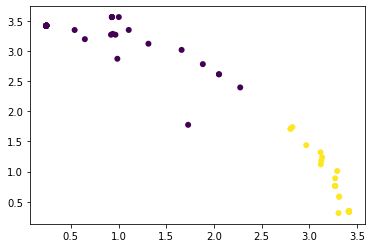

In [48]:
plt.scatter(senator_distances[:,0], senator_distances[:,1], c=labels, linewidths=0)
plt.show()

## Finding the most extreme

In [52]:
extremism = (senator_distances**3).sum(axis=1)
extremism

array([32.67874845, 26.53232295, 39.91878062, 40.01754021, 29.13829736,
       39.91878062, 40.01754021, 39.91878062, 40.01754021, 36.21608334,
       39.91878062, 35.88975006, 39.91878062, 37.71051208, 39.91878062,
       32.22150039, 32.72193513, 40.01754021, 40.01754021, 40.01754021,
       26.53232295, 36.60334976, 40.01754021, 40.01754021, 40.01754021,
       40.01754021, 46.04687308, 40.01754021, 27.75802391, 39.91878062,
       40.01754021, 40.01754021, 39.91878062, 40.01754021, 40.01754021,
       36.60334976, 35.76549954, 39.91878062, 32.94241771, 40.01754021,
       40.01754021, 35.48052818, 25.55784136, 36.27181661, 39.91878062,
       40.01754021, 40.01754021, 40.01754021, 40.01754021, 35.74013614,
       35.48052818, 32.10668699, 31.81620746, 46.04687308, 39.91878062,
       38.93892871, 28.23496639, 39.91878062, 40.01754021, 27.07301769,
       40.01754021, 39.91878062, 39.91878062, 39.91878062, 40.01754021,
       40.01754021, 39.91878062, 39.91878062, 36.76309959, 46.04

In [55]:
votes['extremism'] = extremism
votes.sort_values(['extremism'], ascending=False).head(10)

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047,labels,extremism
98,Wicker,R,MS,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,46.250476
53,Lankford,R,OK,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,46.046873
69,Paul,R,KY,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,46.046873
80,Sasse,R,NE,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,46.046873
26,Cruz,R,TX,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,46.046873
48,Johnson,R,WI,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,40.017540
47,Isakson,R,GA,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,40.017540
65,Murkowski,R,AK,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,40.017540
64,Moran,R,KS,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,40.017540
30,Enzi,R,WY,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,40.017540


## Summary

Clustering is a powerful way to explore data and find patterns. Unsupervised learning is very commonly used with large datasets where it isn't obvious how to start with supervised machine learning. In general, it's a good idea to try unsupervised learning to explore a dataset before trying to use supervised learning machine learning models.